# SWC Case

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.10f}'.format

from sklearn import tree
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import StackingClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, roc_curve

from sklearn.manifold import TSNE
import optuna #Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning.
from optuna.samplers import TPESampler
import pickle
from sklearn.feature_selection import VarianceThreshold


In [2]:
train_data = pd.read_csv('train_data_swc.csv')
test_data = pd.read_csv('test_data_swc.csv') # this is not validation data
example_data = pd.read_csv('example.csv')

In [3]:
print('number of data points in the train data: ' , len(train_data))
print('number of data points in the test data: ' , len(test_data))

number of data points in the train data:  62500
number of data points in the test data:  150000


In [5]:
train_data.head(5)

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_100,x_101,x_102,x_103,x_104,x_105,x_106,x_107,x_108,y
0,0.0000000000,0.0000000000,0.0000000000,0.2000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.2000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,3
1,0.2000000000,0.8000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.6000000000,0.2000000000,0.0000000000,0.0000000000,...,0.2000000000,0.0000000000,0.8000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,9
2,0.0000000000,0.0000000000,0.0000000000,0.4000000000,0.0000000000,0.0000000000,3.2000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.6000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,3
3,0.0000000000,0.0000000000,0.2000000000,0.0000000000,0.0000000000,0.0000000000,0.2000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,3
4,0.0000000000,0.0000000000,0.4000000000,0.0000000000,0.0000000000,0.0000000000,0.4000000000,0.0000000000,0.0000000000,0.6000000000,...,0.0000000000,0.0000000000,0.0000000000,0.6000000000,0.2000000000,0.0000000000,0.0000000000,0.2000000000,0.0000000000,9


In [ ]:
test_data.head(5)

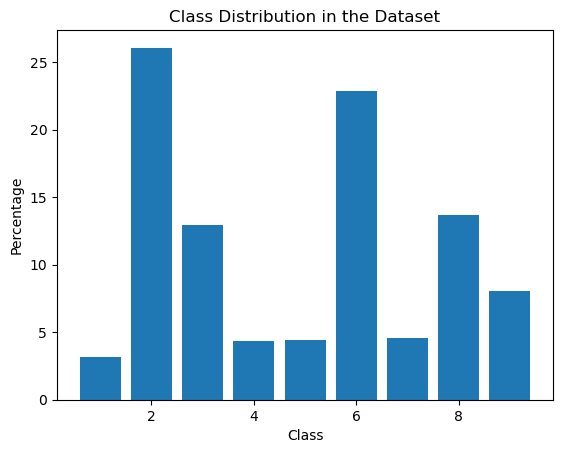

In [4]:
class_counts = train_data['y'].value_counts()
class_percentages = class_counts / len(train_data) * 100
plt.bar(class_percentages.index, class_percentages)
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Class Distribution in the Dataset')
plt.show()

## Preprocessing

### Correlation among Features

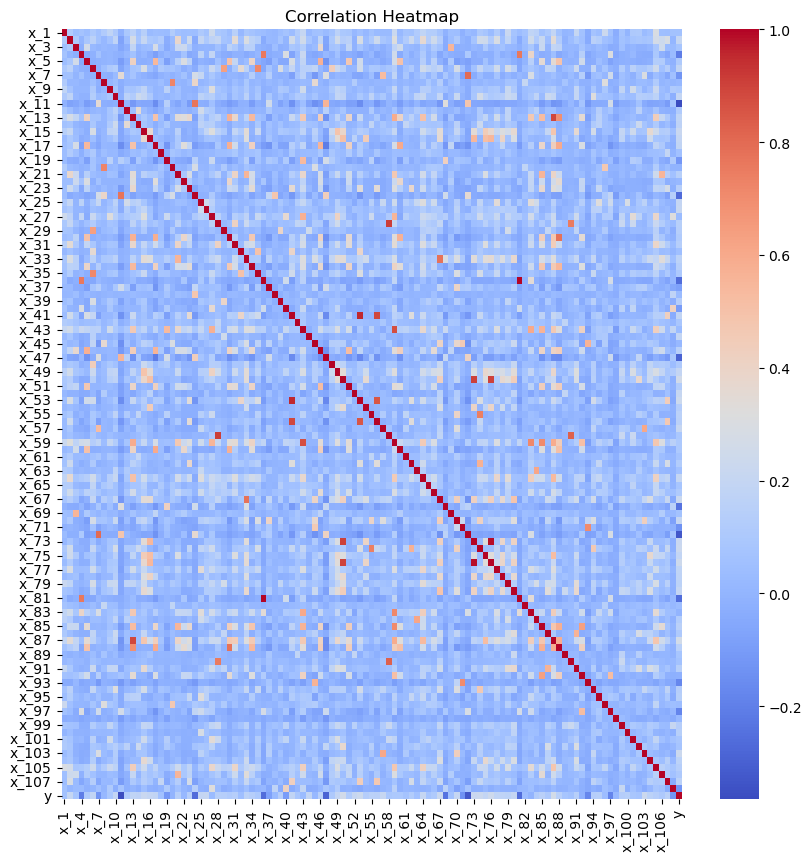

In [26]:
corr_matrix = train_data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [21]:
train_data[train_data.columns[1:]].corr()['y'][:].sort_values(ascending=False)

y       1.0000000000
x_87    0.2613618183
x_50    0.2538531503
x_76    0.2415303223
x_53    0.2352737384
            ...     
x_81   -0.2587749542
x_24   -0.2659279636
x_47   -0.2939078539
x_72   -0.3300052143
x_11   -0.3650183009
Name: y, Length: 108, dtype: float64

## Feature Engineering

### Variance Threshold

In [4]:
X = train_data.iloc[:,0:107]
vt = VarianceThreshold(threshold=0.03)
vt.fit(X)

# find the features that meet the variance threshold
mask = vt.get_support()
chosen_features = list(X.loc[:, mask].columns)
removed_features = [feature for feature in X.columns if feature not in chosen_features]

# show the chosen and removed features
print('Chosen features: ', chosen_features)
print('Removed features: ', removed_features)

Chosen features:  ['x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_19', 'x_20', 'x_21', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_49', 'x_50', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'x_64', 'x_66', 'x_67', 'x_68', 'x_69', 'x_70', 'x_71', 'x_72', 'x_73', 'x_74', 'x_75', 'x_76', 'x_77', 'x_78', 'x_79', 'x_80', 'x_81', 'x_83', 'x_84', 'x_85', 'x_86', 'x_87', 'x_88', 'x_89', 'x_90', 'x_91', 'x_92', 'x_93', 'x_94', 'x_95', 'x_97', 'x_98', 'x_100', 'x_101', 'x_102', 'x_103', 'x_104', 'x_105', 'x_106', 'x_107']
Removed features:  ['x_1', 'x_18', 'x_22', 'x_34', 'x_42', 'x_48', 'x_51', 'x_65', 'x_82', 'x_96', 'x_99']


In [9]:
if(True):    
    test_data = test_data[chosen_features]
    print(len(chosen_features))
    chosen_features.append('y')
    print(len(chosen_features))
    #train_data = train_data[g]
     

KeyError: "['y'] not in index"

### TSNE

In [5]:

X_tsne = TSNE(learning_rate=100).fit_transform(train_data.drop(['y'], axis = 1))
figure(figsize=(10, 5))
scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_data['y'])

NameError: name 'figure' is not defined

In [1]:

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_data['y'])

NameError: name 'plt' is not defined

## ML Models

In [29]:
X = train_data.drop(['y'], axis = 1)
y = train_data['y']
number_f_class = len(y.unique())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13)
print("number of classes: ", number_f_class)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

KeyError: "['y'] not found in axis"

### K-nearest Classifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 1).fit(X_train, y_train) 

predicted = knn.predict(X_test)
predicted_train = knn.predict(X_train)

accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)

print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')

### Naive Bayes Classifier

In [6]:
gnb = GaussianNB().fit(X_train, y_train) 
predicted = gnb.predict(X_test)
predicted_train = gnb.predict(X_train)

accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)

print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')

Accuracy_train: 0.62322
Accuracy_test: 0.63096


### SVM - Linear Kernel

In [27]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 

svm_predictions_train = svm_model_linear.predict(X_train)

# model accuracy for X_train
accuracy_svmlinear_train = svm_model_linear.score(X_train, y_train) 

# model accuracy for X_test   
accuracy_svmlinear_test = svm_model_linear.score(X_test, y_test) 

print(f'Accuracy_train: {accuracy_svmlinear_train}')
print(f'Accuracy_test: {accuracy_svmlinear_test}')

### Decision Tree Model

In [4]:
dt = DecisionTreeClassifier(random_state = 10, max_depth = 22)
dt.fit(X_train, y_train)
predicted = dt.predict(X_test)
predicted_train = dt.predict(X_train)
accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)
print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')

Accuracy_train: 0.86986
Accuracy_test: 0.72584


In [ ]:
#classes = [str(x) for x in train_data['y'].unique().tolist()]
#fig = plt.figure(figsize = (20, ))
#_ = tree.plot_tree(model, feature_names = X.columns.values.tolist(),class_names = classes, filled = True)
#fig.savefig("decision_tree.png")

### Balanced Bagging Classifier

In [15]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#Create an instance
classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=11)
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)
predicted_train = dt.predict(X_train)
accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)
print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')
print(confusion_matrix(y_test, predicted))
print(confusion_matrix(y_train, predicted_train))



Accuracy_train: 0.86986
Accuracy_test: 0.75336
[[ 232   19    2    0    3   14   19   39   52]
 [   6 3134   90   49    6    1   27    3    4]
 [   6 1157  331   54    1    2   42    3    2]
 [   0  257   13  256    1   12   12    2    0]
 [   2   14    0    1  534    0    0    0    1]
 [  78   66    8   22    9 2567   68   43   74]
 [  32   88   22   12    4   21  330   23   10]
 [ 141   56    6    4    4   43   47 1295   34]
 [ 126   48    2    6    0   19   17   34  738]]
[[ 1019    94    14     1     3    78     3   261   101]
 [    8 11641   985    27     6    33    23   233     7]
 [   13  1652  4663    29     0    12    13   105     4]
 [    3   439   262  1366     3    38     7    45     2]
 [    1    50     8     0  2107     5     0    38     2]
 [   21   133    18     5     1 10873    23   224    31]
 [   30   202   102    19     8    66  1671   226     8]
 [   45   105    18     5     2    85     4  6618    28]
 [   73   108    14     1     9    61     5   219  3535]]


### LightGBM Model

In [6]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": number_f_class,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    accuracy_test = accuracy_score(y_test, preds)
    return accuracy_test

In [ ]:

# this part has already been run and we took the required results which are the best parameters
#sampler = TPESampler(seed=1)
#study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)
#print('Best parameters:', study.best_params)
#print('Best value:', study.best_value)
#print('Best trial:', study.best_trial)

In [7]:
# these are the best parameters that have been found by optuna
best_parameters = {'lambda_l1': 5.117571145089835e-06, 'lambda_l2': 0.08753895882464374, 'num_leaves': 199, 'feature_fraction': 0.606773610653303, 'bagging_fraction': 0.8462643326394661, 'bagging_freq': 2, 'min_child_samples': 89}
lgbm = lgb.LGBMClassifier(**best_parameters)
lgbm.fit(X_train, y_train)
predicted = lgbm.predict(X_test)
predicted_train = lgbm.predict(X_train)
accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)
print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')
print(confusion_matrix(y_test, predicted))
print(confusion_matrix(y_train, predicted_train))

y_proba = lgbm.predict_proba(X_test)

# Evaluate the log loss of the stacking classifier (for probabilistic predictions)
log_loss_value = log_loss(y_test, y_proba)
print(f"LGBMC Log Loss: {log_loss_value}")

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=5.117571145089835e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.117571145089835e-06
[LightGBM] [Warning] feature_fraction is set=0.606773610653303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.606773610653303
[LightGBM] [Warning] bagging_fraction is set=0.8462643326394661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462643326394661
[LightGBM] [Warning] lambda_l2 is set=0.08753895882464374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08753895882464374
Accuracy_train: 0.9868
Accuracy_test: 0.834
[[ 200    6    2    0    1   31   11   53   76]
 [   1 2831  417   35    3    8   15    6    4]
 [   2  592  939   29    0    3   29    3    1]
 [   0  137   70  316    1   20    7    1    1]
 [   1    7    0    0  543    1    0    0    0]
 [   8   10    6    1    0 2825   

#### THIS PART IS FOR CREATING THE FINAL DELIVERY

In [8]:
y_probability_final = lgbm.predict_proba(test_data)

In [12]:
y_probability_final = pd.DataFrame(y_probability_final ,columns=['c1','c2','c3','c4','c5','c6','c7','c8','c9'])
y_probability_final.head(5)

,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,0.0000228995,0.4788933556,0.5190286515,0.0018078550,0.0000201671,0.0001349947,0.0000265217,0.0000357280,0.0000298269
1,0.0000001805,0.0000027835,0.0000052295,0.0000005393,0.0000000942,0.0000116264,0.0000013067,0.9999768461,0.0000013938
2,0.0006541911,0.6512843509,0.3039246295,0.0363659532,0.0000145390,0.0008026751,0.0049829059,0.0016067204,0.0003640350
3,0.0002312321,0.0002400645,0.0000590851,0.0002807585,0.0000138374,0.9968207339,0.0002366007,0.0004585852,0.0016591026
4,0.0000136809,0.0497871942,0.0876082636,0.8622524970,0.0000070552,0.0000463739,0.0001185237,0.0001441131,0.0000222984


In [14]:
y_probability_final.to_csv('y_probability_final.csv', index=False, float_format='%.10f')

In [22]:
print(lgbm.feature_importances_)

[ 565 1196  378 2237  108 1894 4624  487  772  938 3506 1480 1982  810
  953  677 1107  104 3827  190  775  464 1041 4295 3426  918 2043 1437
  794  350  363  207 6218  284 1015 3055 4881  955 1775 1864 1322  288
 5532 1468 2607  575 4657  331 1070 2289   86 1987 2348  293  902 1043
 2158  916 3267  422  320 1769  275 1356  309  765 4805 3049  850 6103
 3658 3516  499 3038  223 1897 1238  558  822 1295 1251  110 2264  626
  439  770 2736  422  797  346  407 2033 2367  954 1440  280 2129 1966
  990  626  967  914 2085  861 1141  224  846 2118]


In [27]:
print(y_proba[1])



[1.32843809e-06 1.53260678e-03 9.98422456e-01 3.16270019e-05
 5.92498735e-07 2.58739082e-06 2.61665213e-06 3.52489918e-06
 2.66015686e-06]


## Stacking Ensemble Model

In [21]:
lr_meta = LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42)

# Create the stacking classifier
stacking_clf = StackingClassifier(
    estimators=[('gnb', gnb), ('dt', dt), ('lgbm', lgbm)],
    final_estimator=lr_meta,
    cv=5  # Number of cross-validation folds
)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = stacking_clf.predict(X_test)

# Evaluate the accuracy of the stacking classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Stacking Classifier Accuracy: {accuracy}")


# Make predictions (probabilities) on the test set
y_proba = stacking_clf.predict_proba(X_test)

# Evaluate the log loss of the stacking classifier (for probabilistic predictions)
log_loss_value = log_loss(y_test, y_proba)
print(f"Stacking Classifier Log Loss: {log_loss_value}")

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=5.117571145089835e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.117571145089835e-06
[LightGBM] [Warning] feature_fraction is set=0.606773610653303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.606773610653303
[LightGBM] [Warning] bagging_fraction is set=0.8462643326394661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462643326394661
[LightGBM] [Warning] lambda_l2 is set=0.08753895882464374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08753895882464374
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=5.117571145089835e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.117571145089835e-06
[LightGBM] [Warning] feature_fraction is set=0.606773610653303, colsamp

In [19]:
# Make predictions (probabilities) on the test set
y_proba = stacking_clf.predict_proba(X_test)

# Evaluate the log loss of the stacking classifier (for probabilistic predictions)
log_loss_value = log_loss(y_test, y_proba)
print(f"Stacking Classifier Log Loss: {log_loss_value}")

Stacking Classifier Log Loss: 0.4797681299518584


In [20]:
# Make predictions (probabilities) on the test set
y_proba = stacking_clf.predict_proba(X_train)

# Evaluate the log loss of the stacking classifier (for probabilistic predictions)
log_loss_value_train = log_loss(y_train, y_proba)
print(f"Stacking Classifier Log Loss: {log_loss_value_train}")

Stacking Classifier Log Loss: 0.13507592372013305
